# Formants

Formant is a range of frequencies where there is a local maximum in a sound spectrum. Finding two first formants is enough to disambiguate a vowel. I am going to record myself speaking five vowels: A, I, U, E, O and analyze formants on the recording.

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from IPython.display import display
from ipywidgets import interact, interact_manual, widgets

import collections as col
import concurrent.futures as fts
import contextlib as ctx
import functools as ft
import itertools as it

import numpy as np
import matplotlib.pyplot as plt
from scipy import fftpack, signal
from sklearn import metrics

import paprotka.io as pio
from paprotka.jupyter import *

In [3]:
try:
    example = pio.load_wave('../input/formant-recording.wav')
except FileNotFoundError:
    example = pio.record_sound(10, chunk_size=16)
    pio.save_wave('../input/formant-recording.wav', example)

In [4]:
pio.play_sound(example)

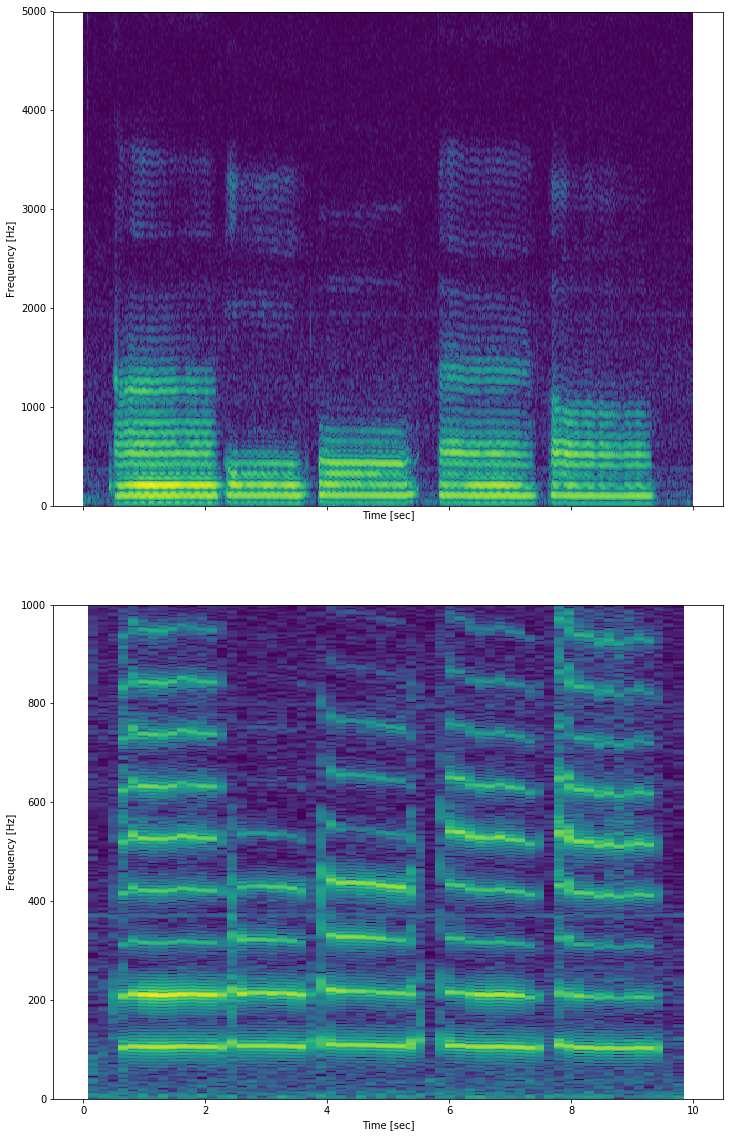

In [5]:
fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True, figsize=(12, 20))
# display_sound(example, root=ax1, show=False)
display_spectrogram(example, root=ax1, show=False, nperseg=1024, nfft=8192, view_range=(0, 5000))
display_spectrogram(example, root=ax2, nperseg=8192, nfft=8*8192, view_range=(0, 1000))

## Analysis of the recording

It seems different sources specify different formant frequencies for vowels. I decided to use the source [here](https://sound.eti.pg.gda.pl/student/amowy/AM_02_teoria_wytwarzania_dzwiekow_mowy.pdf). It's in Polish, so it could be more accurate for a Polish speaker like me. The formant frequencies are here:

<table>
<tr><th>Vowel</th><th>Formant 1</th><th>Formant 2</th><th>Formant 3</th><th>Formant 4</th></tr>
<tr><td>a</td><td>780</td><td>1150</td><td>2700</td><td>3500</td></tr>
<tr><td>i</td><td>210</td><td>2750</td><td>3500</td><td>4200</td></tr>
<tr><td>u</td><td>270</td><td>615</td><td>2200</td><td>3150</td></tr>
<tr><td>e</td><td>380</td><td>2640</td><td>3000</td><td>3600</td></tr>
<tr><td>o</td><td>400</td><td>730</td><td>2300</td><td>3200</td></tr>
</table>

It also says that typical basic frequency for a male speaker is $85-180$Hz, female $165-255$Hz and a child $250-300$Hz. I will also check basic frequency of my voice, since I already have the recording and it is a nice exercise.

Here is a nice visualization:

![Formants visualization](https://www.ruhr-uni-bochum.de/lilab/orga/bilder/Jassem.gif)

## Finding basic frequency

Let's try an autocorrelation method here. First calculate the autocorrelation of example signal. We use fftconvolve function here because it is faster. We pass signal and time-reversed signal, because convolution of those is equivalent to calculating autocorrelation of signal.

Also, we take only a half of the result because the result is symmetric.

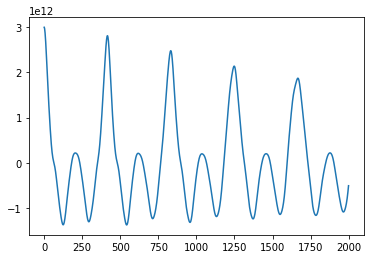

In [6]:
autocorrelation = signal.fftconvolve(example.data, example.data[::-1], 'same')
half_size = autocorrelation.size // 2
autocorrelation_half = autocorrelation[half_size:]

plt.plot(autocorrelation_half[:2000])
plt.show()

Now we look for relative maxima of autocorrelation. We ignore the first peak that autocorrelation starts with, because it only shows that unmoved signal is similar to itself and this is useless for finding a frequency. We also require a peak to be the greatest value in some range (10), but it doesn't really matter in this case since the result is not jagged.

In [7]:
maxima, = signal.argrelmax(autocorrelation_half, mode='clip', order=10)
print(maxima[:10])

maxima_frequencies = example.rate / maxima
print(maxima_frequencies[:10])

relative_maxima = autocorrelation_half[maxima] / autocorrelation_half[maxima].max()
print(relative_maxima[:10])

[ 204  416  617  831 1036 1248 1458 1666 1877 2086]
[ 216.17647059  106.00961538   71.47487844   53.06859206   42.56756757
   35.33653846   30.24691358   26.47058824   23.49493873   21.1409396 ]
[ 0.0763055   1.          0.0737412   0.88172052  0.0697409   0.76051865
  0.07047929  0.6654166   0.07698473  0.61279637]


If we take the first peak as the one where the signal repeats the basic frequency is 216.18Hs, which is too high. The second peak and the frequency of 106Hz seems more reasonable. 

If we look at the values of peaks, the second peak has much higher value. This could mean that the first peak informs us of some small similarity that should be ignored. We can take the values into consideration and ignore peaks that are much lower than the rest to get a sensible frequency. 

In [8]:
relevant_maxima = np.compress(relative_maxima > 0.8, maxima)
print('peak at {} meaning the frequency is {:.4}Hz'.format(relevant_maxima[0], example.rate / relevant_maxima[0]))

peak at 416 meaning the frequency is 106.0Hz


In [9]:
def find_frequency_autocorrelation(sound, order=10, relevant_threshold=0.8):
    data = sound.data
    autocorrelation = signal.fftconvolve(data, data[::-1], 'same')
    half_size = autocorrelation.size // 2
    autocorrelation_half = autocorrelation[half_size:]
    maxima, = signal.argrelmax(autocorrelation_half, mode='clip', order=order)
    maxima_values = autocorrelation_half[maxima]
    relative_maxima_values = maxima_values / maxima_values.max()
    relevant_maxima = np.compress(relative_maxima_values > relevant_threshold, maxima)
    first_maximum = relevant_maxima[0]
    return sound.rate / first_maximum

basic_frequency = find_frequency_autocorrelation(example)
print('basic frequency frequency is {:.4}Hz'.format(basic_frequency))

basic frequency frequency is 106.0Hz


## Finding formants

In [10]:
def cut_sound(sound, start=0, end=None):
    return pio.audio.Sound(
        example.pyaudio_format,
        example.channels,
        example.rate,
        example.sample_width,
        example.data[start:] if end is None else example.data[start:end]
    )

example_cuts = {
    'a': cut_sound(example, 20000, 2 * 41000 + 20000),
    'i': cut_sound(example, 2 * 41000 + 20000, 4 * 41000),
    'u': cut_sound(example, 4 * 41000, 6 * 41000),
    'e': cut_sound(example, 6 * 41000, 8 * 41000),
    'o': cut_sound(example, 8 * 41000)
}

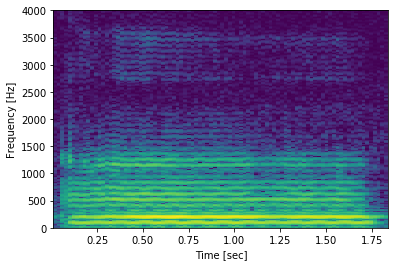

In [11]:
example_a = example_cuts['a']

display_spectrogram(example_a, nperseg=1024, nfft=4*8192, view_range=(0, 4000))

Let's try detecting formants of sound 'a'. We hope to find formants at frequencies 780, 1150, 2700, 3500. In our spectrum of size 82000 and sampling rate 44100, there should be peaks at indices 1450, 2138, 5020 and 6508.

82000


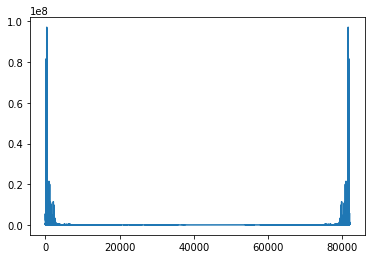

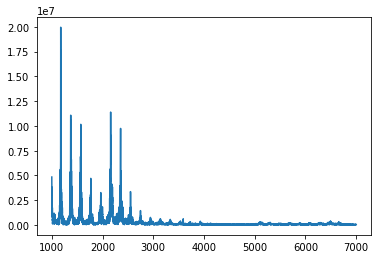

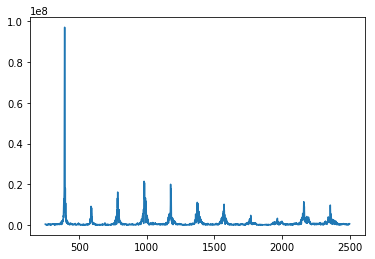

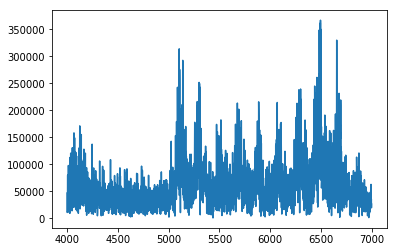

In [12]:
example_a_spectrum = abs(fftpack.fft(example_a.data))
print(example_a_spectrum.size)

plt.plot(example_a_spectrum)
plt.show()

plt.plot(np.arange(1000, 7000), example_a_spectrum[1000:7000])
plt.show()

plt.plot(np.arange(250, 2500), example_a_spectrum[250:2500])
plt.show()

plt.plot(np.arange(4000, 7000), example_a_spectrum[4000:7000])
plt.show()

Well, we found a lot of peaks, which was to be expected. We must select the most significant ones. One thing we must note is that peaks at 5020 and 6508 have much lower energy than those at lower frequencies, but are nevertheless easily distinguishable. So the method of selecting the four peaks can't just take the ones with the largest values.

In [29]:
def binary_search(function, compare_expected, lower, upper):
    if lower > upper:
        return None
    
    middle = (lower + upper) // 2
    result = function(middle)
    comparison_result = compare_expected(result)
    
    if comparison_result == 0:
        return middle, result
    elif comparison_result > 0:
        return binary_search(function, compare_expected, lower, middle - 1)
    else:
        return binary_search(function, compare_expected, middle + 1, upper)

example_a_spectrum_half = example_a_spectrum[:example_a_spectrum.size // 2]
example_a_spectrum_relevant = example_a_spectrum_half[:8000]
    
def peak_search_maker(spectrum):
    def peak_search(order):
        return signal.argrelmax(spectrum, mode='clip', order=order)[0]
    return peak_search

def expect_four(maxima):
    return 4 - maxima.size

found = binary_search(peak_search_maker(example_a_spectrum_relevant), expect_four, 1, example_a_spectrum_relevant.size)
print(found)

# 
# print(example_a_maxima[:10])
# print([1450, 2138, 5020, 6508])

# example_a_maxima_values = abs(example_a_spectrum[example_a_maxima])
# print(example_a_maxima_values[:10])

# most_relevant = np.argpartition(example_a_maxima_values, -4)[:-5:-1]
# example_a_maxima_relevant = example_a_maxima[most_relevant]
# print(example_a_maxima_relevant)

# example_a_maxima_rates = example_a_maxima_relevant * example_a.rate / example_a_spectrum.size
# print(example_a_maxima_rates)

(750, array([ 393, 2160, 5104, 6496]))


Well, instead of 393 we found 1450, but other peaks are very close to 2138, 5020 and 6508. We can consider somewhat acceptable I guess. Let's repeat this procedure for other vowels.

In [31]:
def find_formants(sound, relevant_size=8000, peak_n=4, *args, **kwargs):
    spectrum = abs(fftpack.fft(sound.data))
    spectrum_relevant = spectrum[:relevant_size]
    return binary_search(peak_search_maker(spectrum_relevant), expect_n(peak_n), 1, relevant_size)[1]

example_formants = { key: find_formants(sound) for key, sound in example_cuts.items() }
print(example_formants)

{'e': array([ 393, 2363, 5028, 6444]), 'u': array([ 203, 3591, 5585, 7116]), 'a': array([ 393, 2160, 5104, 6496]), 'o': array([ 264, 1334, 4949, 7908]), 'i': array([ 151, 2715, 4547, 7744])}


If we translate frequencies to peaks, we expected peaks at

<table>
<tr><th>Vowel</th><th>Formant 1</th><th>Formant 2</th><th>Formant 3</th><th>Formant 4</th></tr>
<tr><td>a</td><td>1450</td><td>2138</td><td>5020</td><td>6508</td></tr>
<tr><td>i</td><td>390</td><td>5113</td><td>6507</td><td>7809</td></tr>
<tr><td>u</td><td>502</td><td>1143</td><td>4090</td><td>5857</td></tr>
<tr><td>e</td><td>706</td><td>4908</td><td>5578</td><td>6693</td></tr>
<tr><td>o</td><td>743</td><td>1357</td><td>4276</td><td>5950</td></tr>
</table>

So are very close 3/4 times for 'a', 2/4 times for 'i', 1/4 times for 'u', 2/4 times for 'e', 1/4 times for 'o'. In general this approach failed.

## Summary

I managed to find basic frequency of my voice on the recording. I seem to have failed at finding the formants at expected frequencies.